# Análisis explortario de Datos (EDA) #
### Introducción ##

Importamos las **librerías** que van a ser necesarias para el desarrollo de las pertinentes acciones en este notebook.

In [1]:
import warnings
warnings.simplefilter("ignore")

from graphviz import Source
from IPython.display import Image
from pandas import Series, DataFrame
from scipy.interpolate import interp1d
from scipy.stats import*
from sklearn import metrics
from sklearn import preprocessing
from sklearn import tree
from sklearn import tree, datasets, svm
from sklearn.cluster import KMeans
from sklearn.cross_validation import train_test_split
from sklearn.externals.six import StringIO
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

import ast
import calendar
import csv
import geocoder
import math
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pydot
import pydotplus
import reverse_geocoder as rg
import scipy.fftpack
import seaborn as sns
import sklearn.metrics
import statsmodels.api as sm
import time

C:\Users\grane\Anaconda3\envs\granero\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', 100)
inicio = time.strftime("%c")
%matplotlib inline

In [3]:
df_ori = pd.read_csv('.././PreparacionData/dataCleaning.csv', sep = '|', low_memory=False, parse_dates=[['FECHA','TIEMPO']])
df_ori.head()

,FECHA_TIEMPO,ID,AREA,CODIGO_POSTAL,LATITUD,LONGITUD,LOCALIZACION,CALLE1,CALLE2,CALLE3,PERSONA_LESIONADA,PERSONA_MUERTA,PEATON_LESIONADO,PEATON_MUERTO,CICLISTA_LESIONADO,CICLISTA_MUERTO,MOTORISTA_LESIONADO,MOTORISTA_MUERTO,VEHICULO1,VEHICULO2,VEHICULO3,VEHICULO4,VEHICULO5,FACTOR1,FACTOR2,FACTOR3,FACTOR4,FACTOR5
0,2015-01-01 00:20:00,3146911,QUEENS,11358.0,40.751847,-73.787862,"(40.7518471, -73.787862)",47 AVENUE,193 STREET,NaN,0,0,0,0,0,0,0,0,SPORT UTILITY/STATION WAGON,NaN,NaN,NaN,NaN,TRAFFIC CONTROL DISREGARDED,NaN,NaN,NaN,NaN
1,2015-01-01 00:20:00,3146180,MANHATTAN,NaN,40.771289,-73.946693,"(40.7712888, -73.9466928)",NaN,NaN,NaN,1,0,0,0,0,0,1,0,PASSENGER VEHICLE,NaN,NaN,NaN,NaN,ANIMALS ACTION,NaN,NaN,NaN,NaN
2,2015-01-01 00:21:00,3146384,BROOKLYN,11205.0,40.689445,-73.955121,"(40.6894449, -73.9551212)",BEDFORD AVENUE,LAFAYETTE AVENUE,NaN,0,0,0,0,0,0,0,0,PASSENGER VEHICLE,UNKNOWN,NaN,NaN,NaN,FATIGUED/DROWSY,UNSPECIFIED,NaN,NaN,NaN
3,2015-01-01 00:30:00,3146013,BROOKLYN,11213.0,40.673845,-73.925080,"(40.6738445, -73.9250801)",BUFFALO AVENUE,SAINT MARKS AVENUE,NaN,0,0,0,0,0,0,0,0,BUS,PASSENGER VEHICLE,NaN,NaN,NaN,LOST CONSCIOUSNESS,NaN,NaN,NaN,NaN
4,2015-01-01 00:33:00,3146120,STATEN ISLAND,10301.0,NaN,NaN,NaN,RICHMOND TERRACE,SOUTH AVENUE,NaN,0,0,0,0,0,0,0,0,UNKNOWN,PASSENGER VEHICLE,NaN,NaN,NaN,UNSPECIFIED,UNSPECIFIED,NaN,NaN,NaN


Obtenemos los campos temporales que preveemos que puedan ser necesarios para nuestros análisis. Además generamos un nuevo campo que nos posibilitará clasificar los datos por la estación.

In [4]:
df = df_ori.copy()
df['DIASEMANA'] = pd.to_datetime(df['FECHA_TIEMPO']).dt.dayofweek
df['HORA'] = pd.to_datetime(df['FECHA_TIEMPO']).dt.hour
df['MES'] = pd.to_datetime(df['FECHA_TIEMPO']).dt.month
df['DIA'] = pd.to_datetime(df['FECHA_TIEMPO']).dt.day
df['AÑO'] = pd.to_datetime(df['FECHA_TIEMPO']).dt.year
df['MINUTO'] = pd.to_datetime(df['FECHA_TIEMPO']).dt.minute

df.loc[df['MES'].isin([1,2,3]), 'ESTACION'] = "Invierno"
df.loc[df['MES'].isin([4,5,6]), 'ESTACION'] = "Primavera"
df.loc[df['MES'].isin([7,8,9]), 'ESTACION'] = "Verano"
df.loc[df['MES'].isin([10,11,12]), 'ESTACION'] = "Otoño"
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 477732 entries, 0 to 477731
Data columns (total 35 columns):
FECHA_TIEMPO           477732 non-null datetime64[ns]
ID                     477732 non-null int64
AREA                   448376 non-null object
CODIGO_POSTAL          409793 non-null float64
LATITUD                360637 non-null float64
LONGITUD               360637 non-null float64
LOCALIZACION           356600 non-null object
CALLE1                 364552 non-null object
CALLE2                 335574 non-null object
CALLE3                 58511 non-null object
PERSONA_LESIONADA      477732 non-null int64
PERSONA_MUERTA         477732 non-null int64
PEATON_LESIONADO       477732 non-null int64
PEATON_MUERTO          477732 non-null int64
CICLISTA_LESIONADO     477732 non-null int64
CICLISTA_MUERTO        477732 non-null int64
MOTORISTA_LESIONADO    477732 non-null int64
MOTORISTA_MUERTO       477732 non-null int64
VEHICULO1              473777 non-null object
VEHICULO2     

Como se comentó en el análisis preliminar de limpieza de datos. 

Vamos a realizar el borrado de aquella columnas que poseen más del 85% de sus datos como **NaN** y los cuales no se han podido limpiar.

In [5]:
df.drop(['CALLE3','VEHICULO3','VEHICULO4','VEHICULO5','FACTOR3','FACTOR4','FACTOR5'], axis=1 ,inplace=True)
"""df['AREA']=df['AREA'].fillna('DESCONOCIDO')
df['CODIGO_POSTAL']=df['CODIGO_POSTAL'].fillna('DESCONOCIDO')
df['LATITUD']=df['LATITUD'].fillna('DESCONOCIDO')
df['LONGITUD']=df['LONGITUD'].fillna('DESCONOCIDO')
df['LOCALIZACION']=df['LOCALIZACION'].fillna('DESCONOCIDO')
df['CALLE1']=df['CALLE1'].fillna('DESCONOCIDO')
df['CALLE2']=df['CALLE2'].fillna('DESCONOCIDO')
df['VEHICULO1']=df['VEHICULO1'].fillna('DESCONOCIDO')
df['VEHICULO2']=df['VEHICULO2'].fillna('DESCONOCIDO')
df['FACTOR1']=df['FACTOR1'].fillna('DESCONOCIDO')
df['FACTOR2']=df['FACTOR2'].fillna('DESCONOCIDO')
df['FACTOR1']=df['FACTOR1'].replace('UNSPECIFIED','DESCONOCIDO')
df['FACTOR2']=df['FACTOR2'].replace('UNSPECIFIED','DESCONOCIDO')"""

"df['AREA']=df['AREA'].fillna('DESCONOCIDO')\ndf['CODIGO_POSTAL']=df['CODIGO_POSTAL'].fillna('DESCONOCIDO')\ndf['LATITUD']=df['LATITUD'].fillna('DESCONOCIDO')\ndf['LONGITUD']=df['LONGITUD'].fillna('DESCONOCIDO')\ndf['LOCALIZACION']=df['LOCALIZACION'].fillna('DESCONOCIDO')\ndf['CALLE1']=df['CALLE1'].fillna('DESCONOCIDO')\ndf['CALLE2']=df['CALLE2'].fillna('DESCONOCIDO')\ndf['VEHICULO1']=df['VEHICULO1'].fillna('DESCONOCIDO')\ndf['VEHICULO2']=df['VEHICULO2'].fillna('DESCONOCIDO')\ndf['FACTOR1']=df['FACTOR1'].fillna('DESCONOCIDO')\ndf['FACTOR2']=df['FACTOR2'].fillna('DESCONOCIDO')\ndf['FACTOR1']=df['FACTOR1'].replace('UNSPECIFIED','DESCONOCIDO')\ndf['FACTOR2']=df['FACTOR2'].replace('UNSPECIFIED','DESCONOCIDO')"

Agrupamos en grupos '**agregados**' los diferentes tipos de viandantes.

In [6]:
df['PERSONA']=df['PERSONA_LESIONADA'] + df['PERSONA_MUERTA']

df['PEATON']=df['PEATON_LESIONADO'] + df['PEATON_MUERTO']
df['CICLISTA']=df['CICLISTA_LESIONADO'] + df['CICLISTA_MUERTO']
df['MOTORISTA']=df['MOTORISTA_LESIONADO'] + df['MOTORISTA_MUERTO']


Para seguir la plantilla de trasladar los datos al idioma oficial del TFM, voy a traducir tanto los registros de **`VEHICULO`** como de **`FACTOR`**.

In [7]:
df.replace('SPORT UTILITY/STATION WAGON','VEHICULO DEPORTIVO', inplace =True)
df.replace('PASSENGER VEHICLE','VEHICULO NORMAL', inplace = True)
df.replace('BUS','AUTOBUS', inplace = True)
df.replace('UNKNOWN','DESCONOCIDO', inplace = True)
#df.replace('TAXI','TAXI')
df.replace('VAN','CAMION', inplace = True)
df.replace('FIRE TRUCK',' CAMION DE BOMBEROS', inplace = True)
df.replace('OTHER','OTROS', inplace = True)
df.replace('LARGE COM VEH(6 OR MORE TIRES)','VEHICULO GRANDE', inplace = True)
df.replace('LIVERY VEHICLE','VEHICULO LIGERO', inplace = True)
#df.replace('SCOOTER','SCOOTER')
df.replace('PICK-UP TRUCK','CAMION DE RECOGIDA', inplace = True)
df.replace('AMBULANCE','AMBULANCIA', inplace = True)
df.replace('SMALL COM VEH(4 TIRES)','VEHICULO PEQUEÑO', inplace = True)
df.replace('MOTORCYCLE','MOTOCICLETA', inplace = True)
df.replace('BICYCLE','BICICLETA', inplace = True)
#df.replace('nan',' nan')
df.replace('PEDICAB','TAXIBICI', inplace = True)

In [8]:
df.replace('ACCELERATOR DEFECTIVE','ACELERADOR DEFECTUOSO',inplace = True)
df.replace('AGGRESSIVE DRIVING/ROAD RAGE','CONDUCCIÓN AGRESIVA',inplace = True)
df.replace('ALCOHOL INVOLVEMENT','ALCOHOL',inplace = True)
df.replace('ANIMALS ACTION','ANIMALES',inplace = True)
df.replace('BACKING UNSAFELY','MARCHA ATRAS INSEGURA',inplace = True)
df.replace('BRAKES DEFECTIVE','FRENOS DEFECTUOSOS',inplace = True)
df.replace('CELL PHONE (HAND-HELD)','TELEFONO',inplace = True)
df.replace('CELL PHONE (HANDS-FREE)','TELEFONO (MANOS LIBRES)',inplace = True)
df.replace('DRIVER INATTENTION/DISTRACTION','DISTRACCION',inplace = True)
df.replace('DRIVER INEXPERIENCE','INEXPERIENCIA',inplace = True)
df.replace('DRIVERLESS/RUNAWAY VEHICLE','SIN CARNET DE CONDUCIR',inplace = True)
df.replace('DRUGS (ILLEGAL)','DROGAS',inplace = True)
df.replace('FAILURE TO KEEP RIGHT','NO MANTENER LA DIRECCION',inplace = True)
df.replace('FAILURE TO YIELD RIGHT-OF-WAY','SENTIDO DE LA DIRECCION',inplace = True)
df.replace('FATIGUED/DROWSY','FATIGA',inplace = True)
df.replace('FELL ASLEEP','DORMIRSE',inplace = True)
df.replace('FOLLOWING TOO CLOSELY','DISTANCIA DE SEGURIDAD INSUFICIENTE',inplace = True)
df.replace('GLARE','DESLUMBRAMIENTO',inplace = True)
df.replace('HEADLIGHTS DEFECTIVE','FAROS DEFECUOSOS',inplace = True)
df.replace('ILLNESS','ENFERMEDAD',inplace = True)
df.replace('LANE MARKING IMPROPER/INADEQUATE','SEÑAL DE CARRIL DEFECTUOSO',inplace = True)
df.replace('LOST CONSCIOUSNESS','PERDER LA CONCIENCIA',inplace = True)
df.replace('OBSTRUCTION/DEBRIS','ESCOMBROS',inplace = True)
df.replace('OTHER ELECTRONIC DEVICE','DISTRACCION DISPOSITIVO ELECTRONICO',inplace = True)
df.replace('OTHER LIGHTING DEFECTS','LUCES DEFECTUOSAS',inplace = True)
df.replace('OTHER VEHICULAR','OTRO VEHICULO',inplace = True)
df.replace('OUTSIDE CAR DISTRACTION','DISTRACCION FUERA DEL COCHE',inplace = True)
df.replace('OVERSIZED VEHICLE','COCHE DEMASIADO GRANDE',inplace = True)
df.replace('PASSENGER DISTRACTION','DISTRACCION DE LOS PASAJEROS',inplace = True)
df.replace('PASSING OR LANE USAGE IMPROPER','MAL CAMBIO ENTRE CARRILES',inplace = True)
df.replace('PAVEMENT DEFECTIVE','PAVIMENTO DEFECTUOSO',inplace = True)
df.replace('PAVEMENT SLIPPERY','PAVIMENTO DESLIZANTE',inplace = True)
df.replace('PEDESTRIAN/BICYCLIST/OTHER PEDESTRIAN ERROR/CONFUSION','ERROR DE OTROS VIANDANTES',inplace = True)
df.replace('PHYSICAL DISABILITY','DISCAPACIDAD FISICA',inplace = True)
df.replace('PRESCRIPTION MEDICATION','PRESCIPCION MEDICA',inplace = True)
df.replace('REACTION TO OTHER UNINVOLVED VEHICLE','REACCION MALA A OTROS CONDUCTORES',inplace = True)
df.replace('SHOULDERS DEFECTIVE/IMPROPER','HOMBROS CANSADOS',inplace = True)
df.replace('STEERING FAILURE','DIRECCION DESGASTADA',inplace = True)
df.replace('TIRE FAILURE/INADEQUATE','NEUMATICOS DESGASTADOS',inplace = True)
df.replace('TOW HITCH DEFECTIVE','ENGANCHE DE REMOLQUE DEFECTUOSO',inplace = True)
df.replace('TRAFFIC CONTROL DEVICE IMPROPER/NON-WORKING','DEFECTUOSA SEÑAL DE TRAFICO',inplace = True)
df.replace('TRAFFIC CONTROL DISREGARDED','IGNORAR SEÑAL DE TRAFICO',inplace = True)
df.replace('TURNING IMPROPERLY','GIRO INAPROPIADO',inplace = True)
df.replace('UNSAFE LANE CHANGING','MAL CAMBIO DE CARRIL',inplace = True)
df.replace('UNSAFE SPEED','ALTA VELOCIDAD',inplace = True)
df.replace('UNSPECIFIED','DESCONOCIDO',inplace = True)
df.replace('VIEW OBSTRUCTED/LIMITED','LIMTACION DE VISIBILIDAD',inplace = True)
df.replace('WINDSHIELD INADEQUATE','PARABRISAS DEFECTUOSO',inplace = True)

In [9]:
df

,FECHA_TIEMPO,ID,AREA,CODIGO_POSTAL,LATITUD,LONGITUD,LOCALIZACION,CALLE1,CALLE2,PERSONA_LESIONADA,PERSONA_MUERTA,PEATON_LESIONADO,PEATON_MUERTO,CICLISTA_LESIONADO,CICLISTA_MUERTO,MOTORISTA_LESIONADO,MOTORISTA_MUERTO,VEHICULO1,VEHICULO2,FACTOR1,FACTOR2,DIASEMANA,HORA,MES,DIA,AÑO,MINUTO,ESTACION,PERSONA,PEATON,CICLISTA,MOTORISTA
0,2015-01-01 00:20:00,3146911,QUEENS,11358.0,40.751847,-73.787862,"(40.7518471, -73.787862)",47 AVENUE,193 STREET,0,0,0,0,0,0,0,0,VEHICULO DEPORTIVO,NaN,IGNORAR SEÑAL DE TRAFICO,NaN,3,0,1,1,2015,20,Invierno,0,0,0,0
1,2015-01-01 00:20:00,3146180,MANHATTAN,NaN,40.771289,-73.946693,"(40.7712888, -73.9466928)",NaN,NaN,1,0,0,0,0,0,1,0,VEHICULO NORMAL,NaN,ANIMALES,NaN,3,0,1,1,2015,20,Invierno,1,0,0,1
2,2015-01-01 00:21:00,3146384,BROOKLYN,11205.0,40.689445,-73.955121,"(40.6894449, -73.9551212)",BEDFORD AVENUE,LAFAYETTE AVENUE,0,0,0,0,0,0,0,0,VEHICULO NORMAL,DESCONOCIDO,FATIGA,DESCONOCIDO,3,0,1,1,2015,21,Invierno,0,0,0,0
3,2015-01-01 00:30:00,3146013,BROOKLYN,11213.0,40.673845,-73.925080,"(40.6738445, -73.9250801)",BUFFALO AVENUE,SAINT MARKS AVENUE,0,0,0,0,0,0,0,0,AUTOBUS,VEHICULO NORMAL,PERDER LA CONCIENCIA,NaN,3,0,1,1,2015,30,Invierno,0,0,0,0
4,2015-01-01 00:33:00,3146120,STATEN ISLAND,10301.0,NaN,NaN,NaN,RICHMOND TERRACE,SOUTH AVENUE,0,0,0,0,0,0,0,0,DESCONOCIDO,VEHICULO NORMAL,DESCONOCIDO,DESCONOCIDO,3,0,1,1,2015,33,Invierno,0,0,0,0
5,2015-01-01 00:51:00,3145968,BROOKLYN,11203.0,40.656684,-73.929896,"(40.6566844, -73.9298964)",CLARKSON AVENUE,EAST 51 STREET,2,0,0,0,0,0,2,0,VEHICULO NORMAL,VEHICULO DEPORTIVO,DESCONOCIDO,DESCONOCIDO,3,0,1,1,2015,51,Invierno,2,0,0,2
6,2015-01-01 10:00:00,3146102,QUEENS,11105.0,40.776519,-73.915920,"(40.7765195, -73.91592)",26 STREET,23 AVENUE,0,0,0,0,0,0,0,0,VEHICULO NORMAL,VEHICULO NORMAL,ALCOHOL,DESCONOCIDO,3,10,1,1,2015,0,Invierno,0,0,0,0
7,2015-01-01 10:05:00,3146344,BROOKLYN,11203.0,40.657281,-73.947354,"(40.6572811, -73.9473543)",WINTHROP STREET,NEW YORK AVENUE,0,0,0,0,0,0,0,0,VEHICULO NORMAL,VEHICULO NORMAL,FATIGA,DESCONOCIDO,3,10,1,1,2015,5,Invierno,0,0,0,0
8,2015-01-01 10:06:00,3145900,MANHATTAN,10024.0,40.787223,-73.967926,"(40.7872228, -73.9679255)",WEST 89 STREET,CENTRAL PARK WEST,1,0,1,0,0,0,0,0,VEHICULO NORMAL,NaN,DESCONOCIDO,NaN,3,10,1,1,2015,6,Invierno,1,1,0,0
9,2015-01-01 10:10:00,3145960,BROOKLYN,11223.0,40.593323,-73.964638,"(40.5933231, -73.9646376)",OCEAN PARKWAY,AVENUE W,0,0,0,0,0,0,0,0,VEHICULO NORMAL,VEHICULO NORMAL,DESCONOCIDO,DESCONOCIDO,3,10,1,1,2015,10,Invierno,0,0,0,0


## Análisis con variables espaciales(Distrito)

El primer estudio se va a centrar poder establecer que distritos recogen el mayor número de personas heridas o muertas.

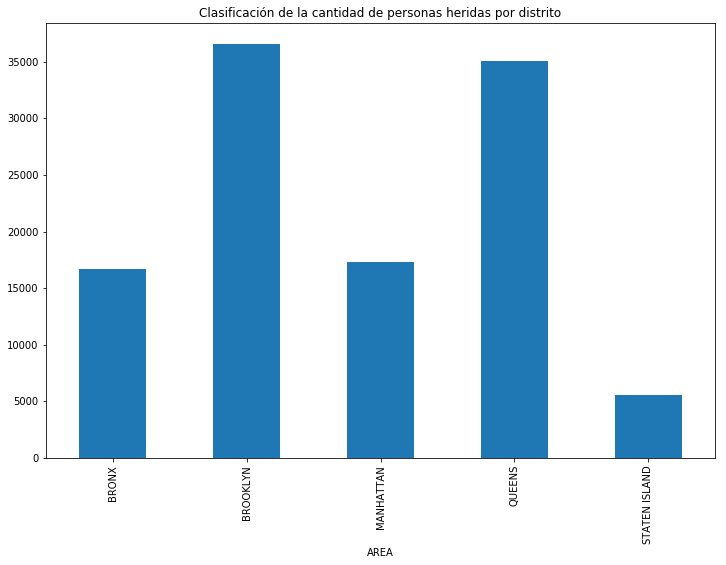

In [10]:
dfarea = df.groupby('AREA')['PERSONA_LESIONADA'].sum()
dfarea
plt.figure(figsize=(12, 8))
dfarea.plot(kind='bar', title='Clasificación de la cantidad de personas heridas por distrito', color="#1F77B4")
plt.savefig('.././Imagenes/EDA/EDA_IMAGEN1.png', bbox_inches='tight')
plt.show()

Claramente sobresalen dos de las 5 áreas. Tendriamos que estudiar comparando con diferentes dataset sobre la población, la cantidad de coches por habitante o incluso el promedio de calles y el tipo de las mismas para poder dar una explicación objetiva a esta realidad.

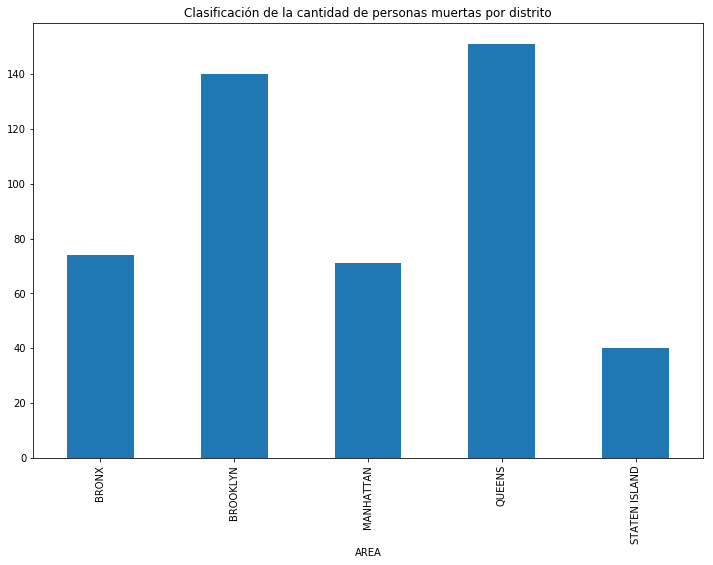

In [11]:
dfarea = df.groupby('AREA')['PERSONA_MUERTA'].sum()
plt.figure(figsize=(12, 8))
dfarea.plot(kind='bar', title='Clasificación de la cantidad de personas muertas por distrito', color="#1F77B4")
plt.savefig('.././Imagenes/EDA/EDA_IMAGEN2.png', bbox_inches='tight')
plt.show()

La relación de los datos es muy semejante al anterior, pero destaca como se tornan el distrito con más personas heridas del apartado anterior en comparación con la de personas muertas.

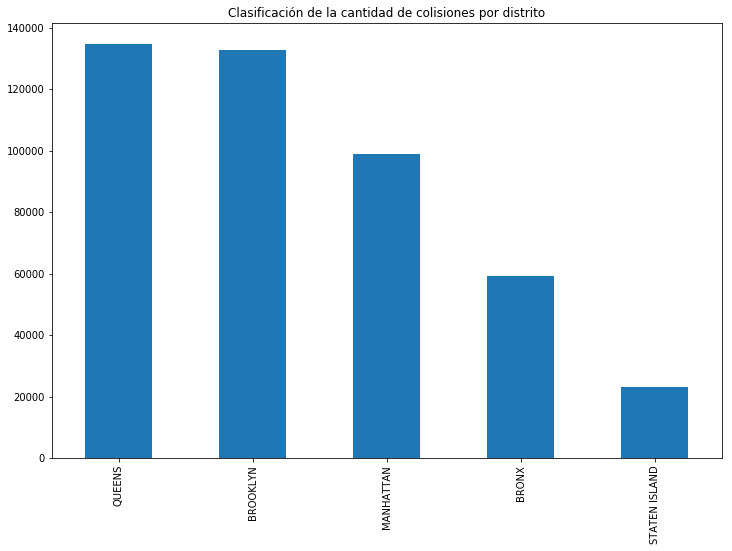

In [12]:
dfarea=df['AREA'].value_counts()
plt.figure(figsize=(12, 8))
dfarea.plot.bar(title='Clasificación de la cantidad de colisiones por distrito', color="#1F77B4")
plt.savefig('.././Imagenes/EDA/EDA_IMAGEN3.png', bbox_inches='tight')
plt.show()

## Análisis con variables temporales

El primer análisis temporal gráfico lo he enfocado en ver cuantas personas han sido lesionadas, heridas o muertas en cualquier colisión dependiento de la estación del año.

In [13]:
estaciones_personas = df.groupby('ESTACION')['PERSONA'].count()
est_index = estaciones_personas.index

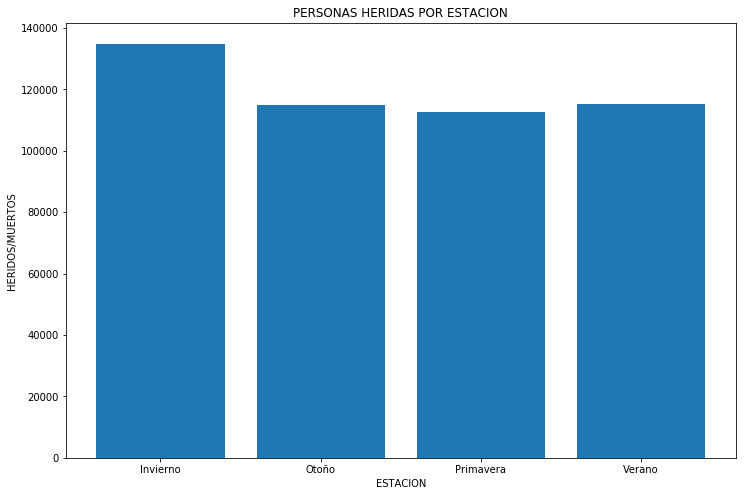

In [14]:
plt.figure(figsize=(12, 8))
plt.bar(est_index, estaciones_personas)
plt.ylabel('HERIDOS/MUERTOS')
plt.xlabel('ESTACION')
plt.title('PERSONAS HERIDAS POR ESTACION')
plt.savefig('.././Imagenes/EDA/EDA_IMAGEN4.png', bbox_inches='tight')
plt.show()

Apreciamos como la mayor parte de los siniestros se producen en la estación de Invierno, esto puede deberse a que son temporadas con más lluvias y fuertes nevadas, todo ello unido al mayor uso de los vehículos de transporte tanto privados como públicos(taxi).

Podemos apreciar de un simple vistazo la distribución de total de personas muertas o heridas dependiendo del año y del distrituto.

In [15]:
area_lesionados_año = df.groupby(['AÑO', 'AREA'])['PERSONA'].sum().unstack()
area_lesionados_año.index = [2015,2016,2017]
area_lesionados_año['TOTAL'] = area_lesionados_año['BRONX'] + area_lesionados_año['BROOKLYN'] + area_lesionados_año['MANHATTAN']  +area_lesionados_año['QUEENS'] + area_lesionados_año['STATEN ISLAND'] 
area_lesionados_año

AREA,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND,TOTAL
2015,7053,15989,7531,15119,2594,48286
2016,8551,18236,8488,17557,2558,55390
2017,1165,2491,1343,2506,479,7984


Como resultado podemos concluir que el año **2016** produjo un casi un 20% más personas heridas que el año anterior y que aumentaron en 4/5 áreas el numero.

Vuelvo a destacar que el año **2017** no se tiene encuenta ya que los datos recogidos solo cubren 2/12 meses.

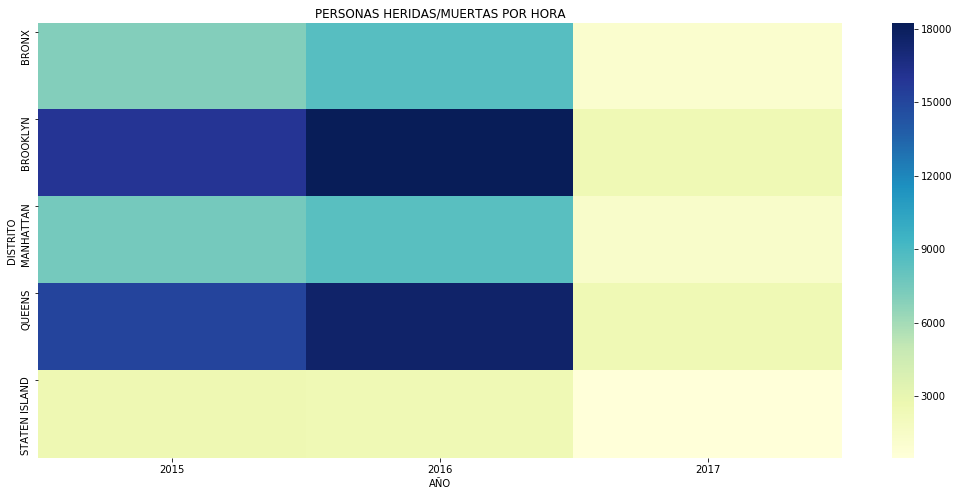

In [16]:
plt.figure(figsize=(18, 8))
sns.heatmap(df.groupby(['AREA','AÑO'])['PERSONA'].sum().unstack(),cmap="YlGnBu")
plt.yticks(np.arange(5) +0.1, (area_lesionados_año.columns))
plt.xticks(np.arange(3) + 0.5)
plt.ylabel('DISTRITO')
plt.xlabel('AÑO')
plt.title('PERSONAS HERIDAS/MUERTAS POR HORA')
plt.savefig('.././Imagenes/EDA/EDA_IMAGEN5.png', bbox_inches='tight')
plt.show()

In [17]:
MesAnual = ['ENERO', 'FEBRERO', 'MARZO', 'ABRIL', 'MAYO', 'JUNIO','JULIO', 'AGOSTO','SEPTIEMBRE', 'OCTUBRE', 'NOVIEMBRE','DICIEMBRE']
area_lesionados_mes = df.groupby(['MES','AREA'])['PERSONA'].sum().unstack()
area_lesionados_mes.index = MesAnual
area_lesionados_mes['TOTAL'] = area_lesionados_mes['BRONX'] + area_lesionados_mes['BROOKLYN'] + area_lesionados_mes['MANHATTAN']  +area_lesionados_mes['QUEENS'] + area_lesionados_mes['STATEN ISLAND'] 
area_lesionados_mes

AREA,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND,TOTAL
ENERO,1609,3633,1729,3484,588,11043
FEBRERO,1439,3129,1666,3011,573,9818
MARZO,1180,2491,1282,2527,378,7858
ABRIL,1367,2840,1333,2500,415,8455
MAYO,1438,3162,1434,3010,502,9546
JUNIO,1286,2911,1328,2972,467,8964
JULIO,1402,3248,1330,3067,457,9504
AGOSTO,1482,3202,1530,2984,424,9622
SEPTIEMBRE,1513,3167,1388,2949,453,9470
OCTUBRE,1440,3011,1585,2964,443,9443


Como ya indicamos al realizar el análisis de colisiones por estaciones, ahora vamos a realizar análisis de gránulo fino(adentrándonos más aún en la materia), pudiendo establecer el peor mes como Enero, destacando esta diferencia otra vez por los distritos **`BROOKLYN`** y **`QUEENS`**

Vamos a realizar una pequeña modificación consistente en cambiar a todo tipo de **viandante** por **ciclista**.

In [18]:
MesAnual = ['ENERO', 'FEBRERO', 'MARZO', 'ABRIL', 'MAYO', 'JUNIO','JULIO', 'AGOSTO','SEPTIEMBRE', 'OCTUBRE', 'NOVIEMBRE','DICIEMBRE']
area_lesionados_mesAño = df.groupby(['MES','AÑO'])['CICLISTA'].sum().unstack()
area_lesionados_mesAño.index = MesAnual
area_lesionados_mesAño['TOTAL'] = area_lesionados_mesAño[2015] + area_lesionados_mesAño[2016] + area_lesionados_mesAño[2017].replace(np.NaN,0)
area_lesionados_mesAño

AÑO,2015,2016,2017,TOTAL
ENERO,116.0,168.0,308.0,592.0
FEBRERO,82.0,168.0,225.0,475.0
MARZO,161.0,311.0,NaN,472.0
ABRIL,306.0,352.0,NaN,658.0
MAYO,475.0,423.0,NaN,898.0
JUNIO,442.0,467.0,NaN,909.0
JULIO,577.0,498.0,NaN,1075.0
AGOSTO,572.0,1237.0,NaN,1809.0
SEPTIEMBRE,519.0,781.0,NaN,1300.0
OCTUBRE,410.0,539.0,NaN,949.0


Podemos apreciar como la tendencia ahora a cambiado, los meses con más lesionados y muertes son los meses de verano, esto es debido al aumento de uso de dicho vehículo con tiempo normalmente soleado.

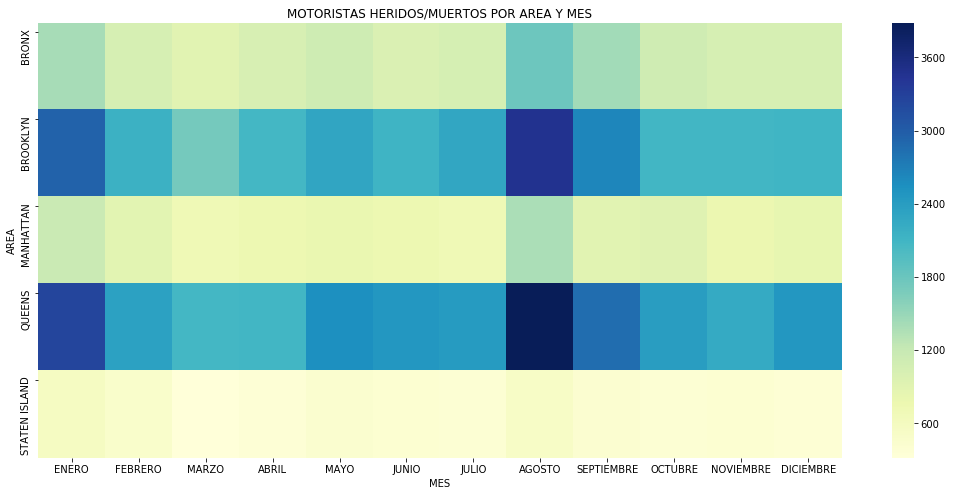

In [19]:
plt.figure(figsize=(18, 8))
sns.heatmap(df.groupby(['AREA','MES'])['MOTORISTA'].sum().unstack(),cmap="YlGnBu")
plt.yticks(np.arange(5) +0.1, (area_lesionados_mes.columns))
plt.xticks(np.arange(12) + 0.5, MesAnual)
plt.ylabel('AREA')
plt.xlabel('MES')
plt.title('MOTORISTAS HERIDOS/MUERTOS POR AREA Y MES')
plt.savefig('.././Imagenes/EDA/EDA_IMAGEN6.png', bbox_inches='tight')
plt.show()

Igual que sucedió con el caso de estudio de los ciclistas, se asemeja con los motoristas. Los meses con mayores tragedias se han producido en Agosto.

Una opción muy interesante sería estudiar nuestro último conjunto de usuarios (**Peatones**) con respecto a las horas del día.

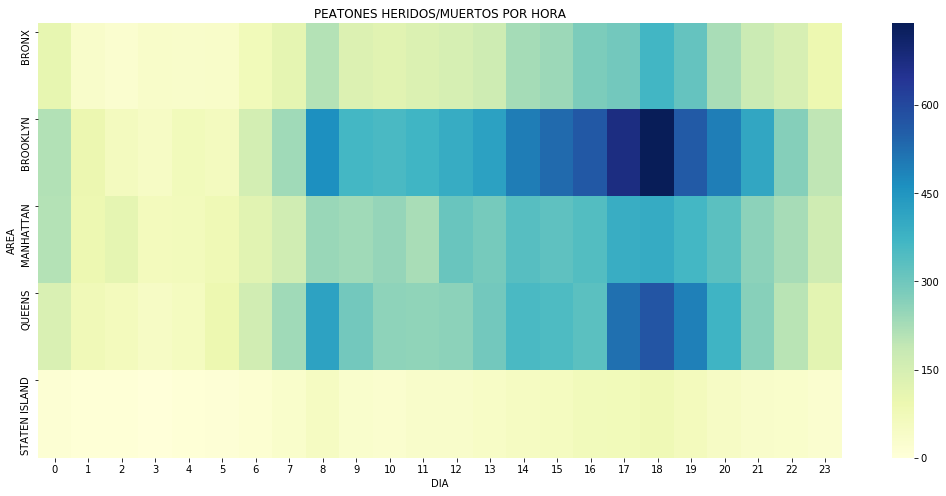

In [20]:
plt.figure(figsize=(18, 8))
sns.heatmap(df.groupby(['AREA','HORA'])['PEATON'].sum().unstack(),cmap="YlGnBu")
plt.yticks(np.arange(5) +0.1)
plt.xticks(np.arange(24) + 0.5, np.arange(24))
plt.ylabel('AREA')
plt.xlabel('DIA')
plt.title('PEATONES HERIDOS/MUERTOS POR HORA')
plt.savefig('.././Imagenes/EDA/EDA_IMAGEN7.png', bbox_inches='tight')
plt.show()

Claramente los horarios en los que más accidentes se producen, es tanto a la entrada de la jornada laboral(aprox 8am) como en la salida (17pm-18pm).

Se podría generar una relación directa entre la mayor afluencia de gente por la calle con los accidentes y el horario laboral.

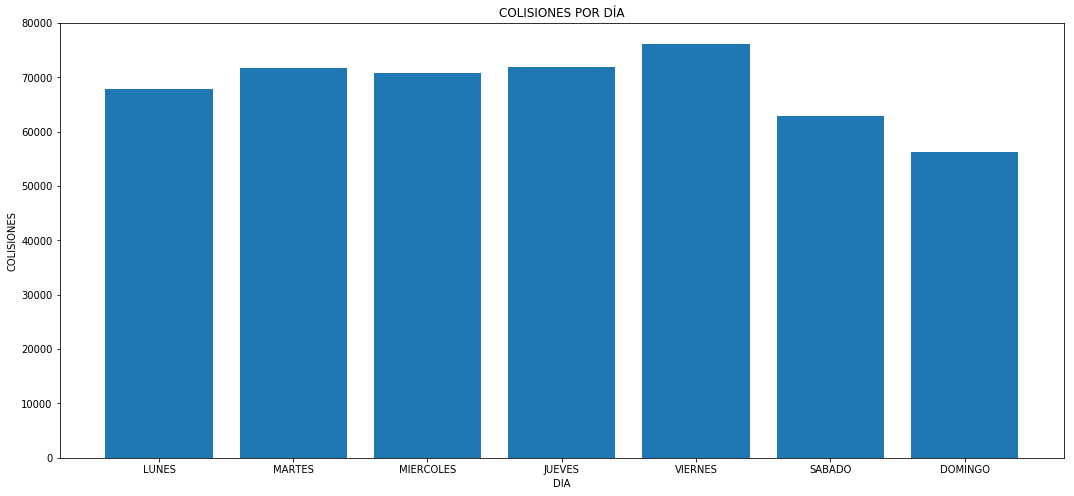

In [21]:
diaSemanal = df.groupby('DIASEMANA').DIASEMANA.count()
plt.figure(figsize=(18, 8))
plt.bar(diaSemanal.index, diaSemanal.values)
plt.xticks(diaSemanal.index, ['LUNES', 'MARTES', 'MIERCOLES', 'JUEVES', 'VIERNES', 'SABADO', 'DOMINGO'])
plt.ylabel('COLISIONES')
plt.xlabel('DIA')
plt.title('COLISIONES POR DÍA')
plt.savefig('.././Imagenes/EDA/EDA_IMAGEN8.png', bbox_inches='tight')
plt.show()

El día que más accidentes se producen son los viernes, coincidiendo con el último día de trabajo, la gente volviendo a sus casas, viajando...

Por último vamos a obtener el día más trágico para cada uno de los 3 años del cojunto de datos.

In [22]:
peorDiaAño = df.groupby(['AÑO','MES','DIA'])['PERSONA_LESIONADA','PERSONA_MUERTA'].sum()
peorDiaAño['TOTAL'] = peorDiaAño['PERSONA_LESIONADA'] + peorDiaAño['PERSONA_MUERTA']
peorDiaAño.sort_values('TOTAL',ascending=False)[:11]

PERSONA_LESIONADA  PERSONA_MUERTA  TOTAL
AÑO  MES DIA                                          
2016 9   30                 254               1    255
         23                 251               1    252
     10  21                 243               1    244
     9   13                 242               1    243
     11  4                  241               1    242
         29                 236               0    236
2015 12  23                 231               1    232
     1   18                 228               0    228
2016 6   26                 227               0    227
     5   20                 224               1    225
2017 2   24                 223               1    224

Podemos observar como los días con más siniestros se ha producido viernes o jueves:
$$ 30/09/2016 --> Viernes $$
$$ 23/12/2015 --> Jueves $$
$$ 24/02/2017 --> Viernes $$

## Análisis con variables categóricas(Factores, Vehiculos)

In [23]:
df['GRAVEDAD']='SIN LESIONES'
lesionados=[x for x in df.columns if 'LESIONADO' in x ] + [x for x in df.columns if 'LESIONADA' in x ]
muertos=[x for x in df.columns if 'MUERTO' in x] + [x for x in df.columns if 'MUERTA' in x]
df.loc[(df[muertos].sum(axis=1)==0)&(df[lesionados].sum(axis=1)>0),'GRAVEDAD']='LESIONADOS'
df.loc[df[muertos].sum(axis=1)>0,'GRAVEDAD']='MUERTOS'
gravedad_total = df.GRAVEDAD.value_counts()
gravedad_total

SIN LESIONES    390399
LESIONADOS       86847
MUERTOS            486
Name: GRAVEDAD, dtype: int64

Aunque vemos que se producen bastante colisiones en todo el conjunto de los cincos distritos de NY para los años analizados, solo un **22%** generan heridos y un **0.12%** muertes. 

Valores relativamente bajos en cuanto a muertes, probablemente porque la velocidad dentro de la ciudad por la cantidad ingente de vehículos no permite adquirir una elevada velocidad. Al ser un pais del "1er mundo", los serviciones de emergencias tambien contribuirán en mantener este número tan bajo.


Podemos generar mayor enfásis en el análisis de los factores que han propiciado los accidentes.

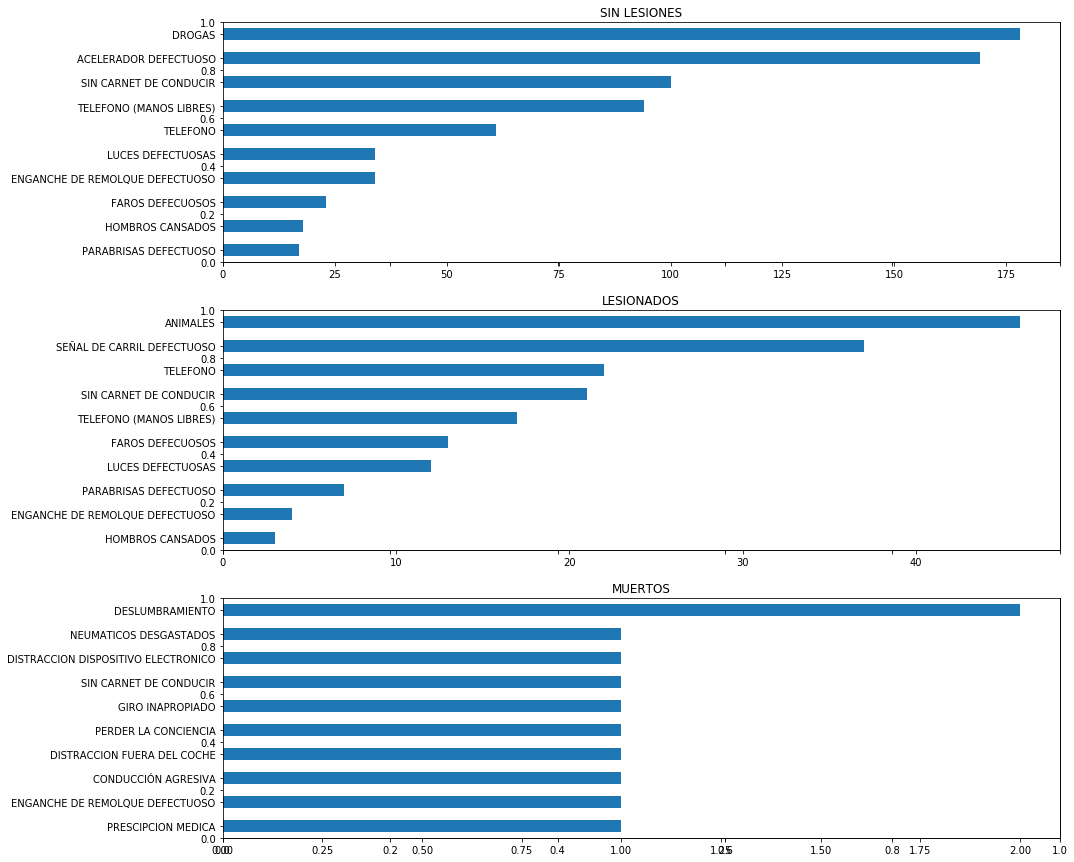

In [24]:
factores = [x for x in df.columns if 'FACTOR' in x]
fact_gravedad = df[factores].join(df['GRAVEDAD'])
sin_les = pd.DataFrame([fact_gravedad.loc[fact_gravedad['GRAVEDAD']=='SIN LESIONES',x].value_counts() for x in factores]).fillna(0).sum().sort_values(ascending=True)
les = pd.DataFrame([fact_gravedad.loc[fact_gravedad['GRAVEDAD']=='LESIONADOS',x].value_counts() for x in factores]).fillna(0).sum().sort_values(ascending=True)
muert = pd.DataFrame([fact_gravedad.loc[fact_gravedad['GRAVEDAD']=='MUERTOS',x].value_counts() for x in factores]).fillna(0).sum().sort_values(ascending=True)


fig, (ax1, ax3, ax4) = plt.subplots(3, 1, figsize=(15,15), sharex=True, sharey=True)

ax1 = fig.add_subplot(311)
sin_les[:10].plot(kind='barh',ax=ax1, title= 'SIN LESIONES', color='#1F77B4')
ax2 = fig.add_subplot(312)
les[:10].plot(kind='barh',ax=ax2, title= 'LESIONADOS', color='#1F77B4')
ax3 = fig.add_subplot(313)
muert[:10].plot(kind='barh',ax=ax3, title= 'MUERTOS', color='#1F77B4')
plt.savefig('.././Imagenes/EDA/EDA_IMAGEN9.png', bbox_inches='tight')
plt.show()

In [25]:
vehicles = df['VEHICULO1'].value_counts().cumsum()/df.shape[0]
top_ve = vehicles[vehicles <= 0.99].index

df.loc[:, 'VEHICULO'] = df['VEHICULO1']
df.loc[~df['VEHICULO'].isin(top_ve), 'VEHICULO'] = 'OTRO'

def gravedad_Cat(df):
  if (df["GRAVEDAD"] == "SIN LESIONES"):
    return 1
  elif (df["GRAVEDAD"] == "LESIONADOS"):
    return 2
  elif (df["GRAVEDAD"] == "MUERTOS"):
    return 3
  else:
    return 0

df["GRAVEDAD_CAT"] = df.apply(gravedad_Cat, axis=1)
df_catalogo = df.groupby(['VEHICULO', 'GRAVEDAD_CAT']).size().groupby(level = [0]).apply(lambda x: x / x.sum()).rename('porcentaje').reset_index()

In [26]:
df_catalogo

,VEHICULO,GRAVEDAD_CAT,porcentaje
0,AUTOBUS,1,0.855396
1,AUTOBUS,2,0.141442
2,AUTOBUS,3,0.003162
3,BICICLETA,1,0.188023
4,BICICLETA,2,0.806825
5,BICICLETA,3,0.005151
6,CAMION,1,0.855468
7,CAMION,2,0.143183
8,CAMION,3,0.001349
9,CAMION DE RECOGIDA,1,0.860644


Podemos generar mayor enfásis en el análisis de los vehículos involucrados en los accidentes.

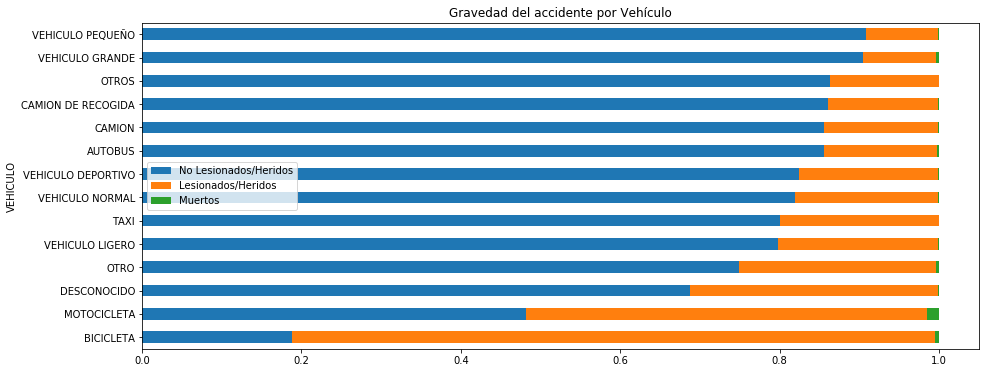

In [27]:
df_cat = df.groupby(['VEHICULO', 'GRAVEDAD_CAT']).size().groupby(level = [0]).apply(lambda x: x / x.sum()).unstack()
x = df_catalogo[df_catalogo['GRAVEDAD_CAT'] == 1].sort_values('porcentaje', ascending = True).VEHICULO.values
df_cat.loc[x].plot(kind = 'barh', title= 'Gravedad del accidente por Vehículo', stacked = True, figsize = (15, 6))
plt.legend(labels = ['No Lesionados/Heridos', 'Lesionados/Heridos','Muertos'])
plt.savefig('.././Imagenes/EDA/EDA_IMAGEN10.png', bbox_inches='tight')
plt.show()

Apreciamos que conforme el vehículo es menos seguro se generan mayores muertes y lesiones, de ahí que las **ciclistas** y los **motoristas** sean el sector más perjudicado.

## Análisis con variables geolocalizables

Gracias a que tanto el campo longitud como latitud son campos numéricos(podemos situarlos en una gráfica) van a ser usados para dibujar directamente cada uno de los usuarios heridos y muertos.

Por el alto número de registros de los que poseemos, la figura para la gente lesionada va a calcar perfectamente la forma de los cinco distritos.

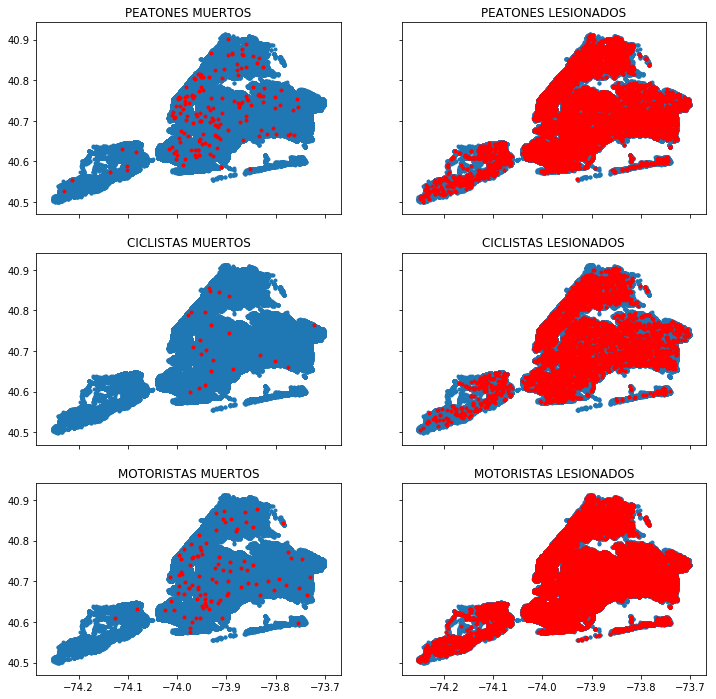

In [28]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12,12) , sharex=True, sharey=True)
df_filterd=df.loc[(df['LATITUD'] <= 49) & (df['LONGITUD'] >= -75 )& (df['LONGITUD'] <= -73)]

muertos = df_filterd['PEATON_MUERTO'].nonzero()[0]
ax1.scatter(df_filterd.LONGITUD,df_filterd.LATITUD, marker='.')
ax1.scatter(df_filterd.LONGITUD[muertos][:],df_filterd.LATITUD[muertos][:],c='red',marker='.')
ax1.title.set_text('PEATONES MUERTOS')

muertos = df_filterd['PEATON_LESIONADO'].nonzero()[0]
ax2.scatter(df_filterd.LONGITUD,df_filterd.LATITUD, marker='.')
ax2.scatter(df_filterd.LONGITUD[muertos][:],df_filterd.LATITUD[muertos][:],c='red',marker='.')
ax2.title.set_text('PEATONES LESIONADOS')

muertos = df_filterd['CICLISTA_MUERTO'].nonzero()[0]
ax3.scatter(df_filterd.LONGITUD,df_filterd.LATITUD, marker='.')
ax3.scatter(df_filterd.LONGITUD[muertos][:],df_filterd.LATITUD[muertos][:],c='red',marker='.')
ax3.title.set_text('CICLISTAS MUERTOS')

muertos = df_filterd['CICLISTA_LESIONADO'].nonzero()[0]
ax4.scatter(df_filterd.LONGITUD,df_filterd.LATITUD, marker='.')
ax4.scatter(df_filterd.LONGITUD[muertos][:],df_filterd.LATITUD[muertos][:],c='red',marker='.')
ax4.title.set_text('CICLISTAS LESIONADOS')

muertos = df_filterd['MOTORISTA_MUERTO'].nonzero()[0]
ax5.scatter(df_filterd.LONGITUD,df_filterd.LATITUD, marker='.')
ax5.scatter(df_filterd.LONGITUD[muertos][:],df_filterd.LATITUD[muertos][:],c='red',marker='.')
ax5.title.set_text('MOTORISTAS MUERTOS')


muertos = df_filterd['MOTORISTA_LESIONADO'].nonzero()[0]
ax6.scatter(df_filterd.LONGITUD,df_filterd.LATITUD, marker='.')
ax6.scatter(df_filterd.LONGITUD[muertos][:],df_filterd.LATITUD[muertos][:],c='red',marker='.')
ax6.title.set_text('MOTORISTAS LESIONADOS')
plt.savefig('.././Imagenes/EDA/EDA_IMAGEN11.png', bbox_inches='tight')
plt.show()




In [29]:
df_cleaned = df_filterd.copy()

df_cleaned.to_csv('.././PreparacionData/dataTableau.csv',sep = '|', header=True, index=False)

In [30]:
fin = time.strftime("%c")
print ("La ejecución completa ha comprendido entre: " + inicio + ' y ' + fin)


La ejecución completa ha comprendido entre: Wed Jun 27 12:01:40 2018 y Wed Jun 27 12:12:12 2018
